# Dealing with unbalanced classes

In this notebook, we will look at some ways to deal with unbalanced classes. 

**NOTE: Later in this notebook, we will use some packages you probably haven't installed in your environment. So now is a good time to install the packages `imblearn` - you might need to use `pip install` to install it.** 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

We will again use the diabetes dataset as example:

In [2]:
diab_data = pd.read_csv('diabetes.csv')

In [3]:
diab_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


For simplicity, we will select only the "Glucose", "BloodPressure", "Insulin", and "BMI" as feature variables, and Outcome as response variable.

In [4]:
X = diab_data[["Glucose", "BloodPressure", "Insulin", "BMI"]]
y = diab_data["Outcome"]

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Glucose        768 non-null    int64  
 1   BloodPressure  768 non-null    int64  
 2   Insulin        768 non-null    int64  
 3   BMI            768 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 24.1 KB


In [6]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 768 entries, 0 to 767
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


Let us just look at how many of each value of the response variable we have:

In [7]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

We have approximate twice as many 1's and 0's, so we clearly have an unbalanced dataset. 

The first thing we want to make sure of is that not all data points from the rare class either end up in the training set or test set. We want approximately equal portion of the rare class in both training and test set, In other words we want a stratified train-test split, which we can do in the following way:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64632, stratify=y)

In [9]:
y_train.value_counts()

Outcome
0    400
1    214
Name: count, dtype: int64

In [10]:
214/400

0.535

In [11]:
y_test.value_counts()

Outcome
0    100
1     54
Name: count, dtype: int64

In [12]:
54/100

0.54

We see, we get very close to the same proportions in the training and in the test set.

To have a model to compare against, let us first train a random forest model on the training data, without doing anythong about the unbalanced data yet.

Test accuracy: 0.7792207792207793
Precision: 0.7941176470588235
Recall: 0.5
f1: 0.6136363636363636


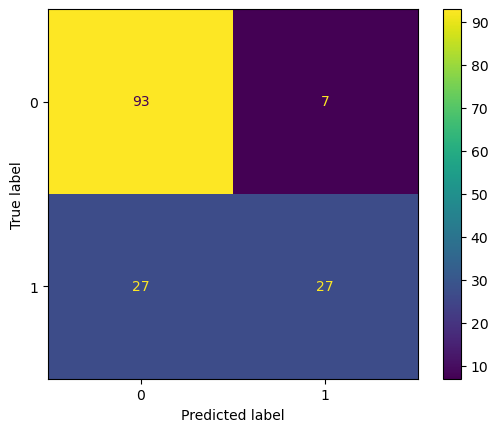

In [13]:
rf_model = RandomForestClassifier(n_estimators = 800, max_depth = 4) 

rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("f1:", f1_score(y_test, y_pred_test))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

## Oversampling the minority class

Let us first do simple oversampling of the data points from the minority class. That is, we sample with replacement from the minority class until we have as many data points as there are in the majority class.

First, we get the indicies for each class.

In [14]:
from sklearn.utils import resample

minority_class_index = y_train[y_train == 1].index
majority_class_index = y_train[y_train == 0].index

Then we do the actual oversampling of based on the minority indices:

In [15]:
over_sample_index = resample(minority_class_index, replace=True, n_samples=len(majority_class_index), random_state=17)

We then creat the total indicies of both classes:

In [16]:
over_sample_indexes = over_sample_index.union(majority_class_index)

We then create new training X and y based on these indicies:

In [17]:
X_train_os = X_train.loc[over_sample_indexes, :]
y_train_os = y_train[over_sample_indexes]
print("X_train_os shape:", X_train_os.shape)
print("y_train_os shape:", y_train_os.shape)

X_train_os shape: (800, 4)
y_train_os shape: (800,)


In [18]:
y_train_os.value_counts()

Outcome
0    400
1    400
Name: count, dtype: int64

We see that we have now increased our training data set to contain 400 data points with $y=1$ and 400 data points with $y=0$. We can then try to train a random forest model on this new data:

Test accuracy: 0.7922077922077922
Precision: 0.7115384615384616
Recall: 0.6851851851851852
f1: 0.6981132075471698


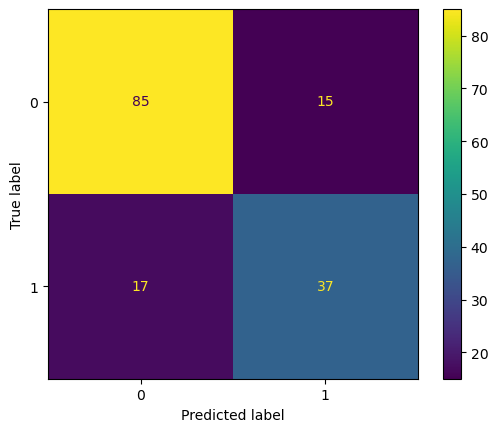

In [19]:
rf_model_os = RandomForestClassifier(n_estimators = 800, max_depth = 4) 

rf_model_os.fit(X_train_os, y_train_os)

y_pred_train_os = rf_model_os.predict(X_train_os)
y_pred_test_os = rf_model_os.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_test_os))
print("Precision:", precision_score(y_test, y_pred_test_os))
print("Recall:", recall_score(y_test, y_pred_test_os))
print("f1:", f1_score(y_test, y_pred_test_os))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_os)).plot()
plt.show()

Not that the overall accuracy did not improve much, but the recall and f1-score improved quite a lot! Not also that we do not oversample the test set, which we take as is. 

## Undersampling the majority class

Now we instead do simple undersampling of the data points from the majority class. That is, we only sample (without replacement) some of the data points from the majority class, such that we get equal amount of data points in the two classes.

First, we get the indicies for each class.

In [20]:
under_sample_index = resample(majority_class_index, replace=False, n_samples=len(minority_class_index), random_state=17)

We then creat the total indicies of both classes:

In [21]:
under_sample_indexes = under_sample_index.union(minority_class_index)

We then create new training X and y based on these indicies:

In [22]:
X_train_us = X_train.loc[under_sample_indexes, :]
y_train_us = y_train[under_sample_indexes]
print("X_train_us shape:", X_train_us.shape)
print("y_train_us shape:", y_train_us.shape)

X_train_us shape: (428, 4)
y_train_us shape: (428,)


In [23]:
y_train_us.value_counts()

Outcome
0    214
1    214
Name: count, dtype: int64

We see that we have now decreased our training data set to contain only 214 data points with $y=1$ and only 214 data points with $y=0$. We can then try to train a random forest model on this new data:

Test accuracy: 0.7467532467532467
Precision: 0.5949367088607594
Recall: 0.8703703703703703
f1: 0.706766917293233


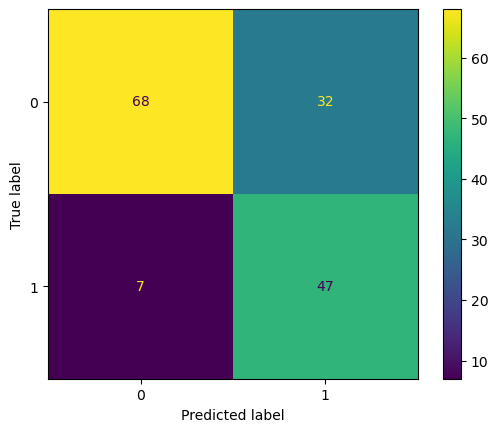

In [24]:
rf_model_us = RandomForestClassifier(n_estimators = 800, max_depth = 4) 

rf_model_us.fit(X_train_us, y_train_us)

y_pred_train_us = rf_model_us.predict(X_train_us)
y_pred_test_us = rf_model_us.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_test_us))
print("Precision:", precision_score(y_test, y_pred_test_us))
print("Recall:", recall_score(y_test, y_pred_test_us))
print("f1:", f1_score(y_test, y_pred_test_us))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_us)).plot()
plt.show()

Not that compared to oversampling, we get much higher recall and also higher f1-score, however, we also get much lower precision and a little lower accuracy. It is not always obvious in advance whether undersampling or over sampling is best.

## SMOTE

Now let us try to use SMOTE intsead. To do this we first have to a new module called [imblearn](https://imbalanced-learn.org/stable/index.html).

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
SMOTE_oversample = SMOTE()
X_train_smote, y_train_smote = SMOTE_oversample.fit_resample(X_train, y_train)

In [27]:
X_train_smote.shape

(800, 4)

In [28]:
y_train_smote.shape

(800,)

We see it oversampled to get 400 data points of each class. Let us see if we get a better random forest model than on the simple oversampling.

Test accuracy: 0.7727272727272727
Precision: 0.6862745098039216
Recall: 0.6481481481481481
f1: 0.6666666666666666


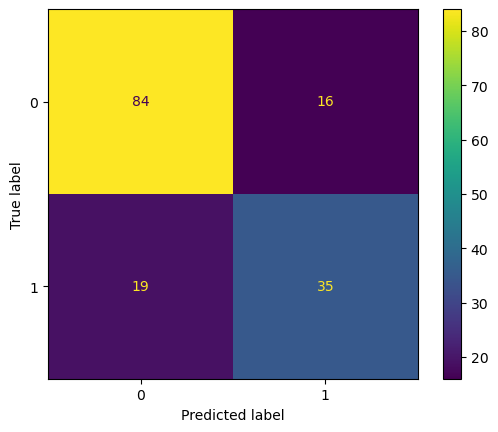

In [29]:
rf_model_smote = RandomForestClassifier(n_estimators = 800, max_depth = 4) 

rf_model_smote.fit(X_train_smote, y_train_smote)

y_pred_train_smote = rf_model_smote.predict(X_train_smote)
y_pred_test_smote = rf_model_smote.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_test_smote))
print("Precision:", precision_score(y_test, y_pred_test_smote))
print("Recall:", recall_score(y_test, y_pred_test_smote))
print("f1:", f1_score(y_test, y_pred_test_smote))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_smote)).plot()
plt.show()

In this case, the SMOTE did not perform better than the simple oversampling. Sometimes it might however, and there is also a lot more from the `imblearn` package we can try out.

In [30]:
dtree = dtree.fit(X_train, y_train)

NameError: name 'dtree' is not defined

In [ ]:
y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
plt.show()

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
accuracy_score(y_test, y_pred_test)

There is no doubt that the decision tree clearly overfitted!!!

In [ ]:
precision_score(y_train, y_pred_train)

In [ ]:
precision_score(y_test, y_pred_test)

In [ ]:
recall_score(y_train, y_pred_train)

In [ ]:
recall_score(y_test, y_pred_test)

In [ ]:
f1_score(y_train, y_pred_train)

In [ ]:
f1_score(y_test, y_pred_test)

### Visualizing a decision tree

We can also visualize our decision tree here in the jupyter notebook. Note that decisions trees can become quite big and complex, but it can still be valuable to try to visualize them. To do this, the modules `graphviz` and `pydotplus` needs to be installed into your environment.

In [ ]:
from sklearn.tree import export_graphviz
#from IPython.display import Image  
import pydotplus

In [ ]:
feature_cols = ["Glucose", "BloodPressure", "Insulin", "BMI"]

export_graphviz(dtree,
                out_file='DT_diabetes.dot',  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['0','1'])

In [ ]:
! dot -Tpng DT_diabetes.dot -o DT_diabetes.png

from IPython import display
display.Image("DT_diabetes.png")

It is clearly a very large and complex decision tree and that is probably also why it overfitted. 

### Hyper-parameter tuning

As we saw the decision tree completely overfitted to the training data! Luckily, there are several hyper-parameters we can tune to make it overfit less. Two of them are:

* **criterion**: Measure of the quality of a split of a column. Mainly *gini* and *entropy*
* **max_depth**: The maximum depth of the tree

We can use cross-validation with different values for `criterion` and `max_depth` to determine the potential optimal tune.

In [ ]:
criterions = ["gini", "entropy"]
maxDepth = range(1, 30)

In [ ]:
CVlist = []
for c in criterions:
    for md in maxDepth:
        # Model intializing
        dtree = DecisionTreeClassifier(criterion=c, max_depth=md)
        # Cross-validation
        scores = cross_val_score(dtree, X_train, y_train, cv = 10)
        CVlist.append({"Criteria": c, "Max depth": md, "CV accuracy": scores.mean()})   
CV_df = pd.DataFrame(CVlist)

In [ ]:
CV_df.head()

In [ ]:
sns.lineplot(data=CV_df, x="Max depth", y="CV accuracy", hue="Criteria", style="Criteria", markers=True)
plt.show()

It looks like the best decision tree is obtained by setting max depth to 2 and the spliting criteria to "entropy", so let us try to do that and evaluate the model on the test dataset:

In [ ]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth=2)
dtree = dtree.fit(X_train, y_train)
y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
accuracy_score(y_test, y_pred_test)

There is clearly less overfitting! However, there might be some issue with class balance as only 28 are predicted to have diabetes, while 126 are predicted to not having diabetes. This also indicated by the decent precision, but low recall:

In [ ]:
precision_score(y_test, y_pred_test)

In [ ]:
recall_score(y_test, y_pred_test)

In [ ]:
f1_score(y_test, y_pred_test)

Let us visualize this tree as well:

In [ ]:
feature_cols = ["Glucose", "BloodPressure", "Insulin", "BMI"]

export_graphviz(dtree,
                out_file='DT_diabetes_tuned.dot',  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['0','1'])

In [ ]:
! dot -Tpng DT_diabetes_tuned.dot -o DT_diabetes_tuned.png

from IPython import display
display.Image("DT_diabetes_tuned.png")

Now, it is not a perfect tree, but certainly easier to grasp, due to its smaller size.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier() 
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
accuracy_score(y_test, y_pred_test)

It looks like we clearly overfitted again. However, usually Random Forest models are not that prone to overfitting.

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
plt.show()

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

It looks like we have to do some hyper-parameter tuning again. For Random forest there are many hyper-parameters we can tune, but we will only look at two, the number of trees (called `n_estimators` in `RandomForestClassifier`) and the max depth (called `max_depth` in `RandomForestClassifier`). (Other important hyper-parameters one could tune is the minimum number of samples required to split a note and the number of features considered at each split.) We will do this using cross-validation:

In [ ]:
nTrees = [200, 400, 600, 800]
maxDepth = [2, 4, 6, 8, 10]

CVlist = []
for nt in nTrees:
    print("Trying ", nt, " number of trees")
    for md in maxDepth:
        print("Trying a max depth of ", md)
        # Model intializing
        rf_model = RandomForestClassifier(n_estimators=nt, max_depth=md)
        # Cross-validation
        scores = cross_val_score(rf_model, X_train, y_train, cv = 10)
        CVlist.append({"Number of trees": nt, "Max depth": md, "CV accuracy": scores.mean()})   
CV_df = pd.DataFrame(CVlist)

Note that this took a long time! We had 4 different number of trees and 5 different number of depth, which means we have to search through 30 combinations of these two hyper-parameters, and for each of these combinations, we trained 10 models (due to 10-fold cross-validation). Thus, in total, we just trained 200 models (each of which consisted of between 200 and 800 decision trees)!!! Essentially, we did what is called grid search, which means we searched all combinations of parameters, which grows exponentially in the number of hyper-parameters. Luckily, there are smarter ways of searching the hyper-parameter space.

Let us plot the cross-validation accurcy across the number of trees and max depth:

In [ ]:
sns.lineplot(data=CV_df, x="Max depth", y="CV accuracy", hue="Number of trees", style="Number of trees", markers=True)
plt.show()

It looks like good option for `n_estimators` and `max_depth` is 800 and 4. Thus, we train a new model on all the training data with these hyper-parameter values:

In [ ]:
rf_model_final = RandomForestClassifier(n_estimators = 800, max_depth = 4) 
rf_model_final.fit(X_train, y_train)
y_pred_train = rf_model_final.predict(X_train)
y_pred_test = rf_model_final.predict(X_test)

In [ ]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Train accuracy:", accuracy_train)
print("Test accuracy:", accuracy_test)

We see that the model no longer overfit as much, but it has not improved the test accuracy. Let us look at the confusion matrix on the test dataset:

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

Here we see that we manage to move one false positives into true negatives, but it also moved one true positive into a false negative. Let us also calculate the other evaluation metrics:

In [ ]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Let us finally look at the variable importance to tell us which feature variables are most important in the model's predictions:

In [ ]:
# Collecting the feature importances
feature_importances = pd.Series(rf_model_final.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plotting the feature impartances
feature_importances.plot.barh()
plt.title("Variable importance for the final Random Forest classifier")
plt.show()

We see that the Glucose level is clearly the most important feature followed by BMI.

### AdaBoost 

AdaBoost is an example of a powerful boosting algorithm. To use it we need to import the `AdaBoostClassifier` from `sklearn.ensemble`:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

We can now train an AdaBoost model the way we trained the random forest model:

In [ ]:
ab_model = AdaBoostClassifier() 
ab_model.fit(X_train, y_train)
y_pred_train = ab_model.predict(X_train)
y_pred_test = ab_model.predict(X_test)

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
accuracy_score(y_test, y_pred_test)

The AdaBoost model does not overfit that much out of the box! Let us look at the Confusion matrix for the test dataset:

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

It makes 4 more false positive than our final Random Forest model, but also 4 less false negatives. Let us also calculate the other evaluation metrics:

In [ ]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

It achieved sligtly lower precision, but substainlly higher recall and thereby also a higher f1-score.

Let us look at the variable importance also:

In [ ]:
# Collecting the feature importances
feature_importances = pd.Series(ab_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plotting the feature impartances
feature_importances.plot.barh()
plt.title("Variable importance for the AdaBoost classifier")
plt.show()

Here we get almost the same as for the Random Forest except that the Insulin feature seems not to be used at all.

If you want, you can try to tune some of AdaBoost's hyper-parameters on your own. Some important hyper-parameters are:
* **n_estimators**: Number of trees that are trained iteratively.
* **learning_rate**: It contributes to the weights of the trees. It uses 1 as a default value.

### XGBoost

XGBoost is another powerful and very popular variant of a boosting model based on decision trees. There seems to be no implementation of it in Scikit-learn, so we will use a separate module (also used by Shabab in the class on Time Series Analysis).

In [ ]:
import xgboost as xgb

Even though it is not standard Scikit-learn, we can set-up it up the usual way:

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
accuracy_score(y_test, y_pred_test)

It clearly overfitted quite a lot, but that is one of the challenges of XGBoost. We will not do hyper-parameter tuning here, but it would be required to get a good model!

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
plt.show()

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

In [ ]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Clearly here we got a lower precision on our test data. Let us see the variable importance as well:

In [ ]:
# Collecting the feature importances
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plotting the feature impartances
feature_importances.plot.barh()
plt.title("Variable importance for the XGBoost classifier")
plt.show()

It still put Glucose on top, but the other variables have more importance now.

### Decision trees and ensemble methods for regression

As mentioned several times, Decision trees and ensemble methods can also be used for regression. For instance, the Scikit-learn submodule `sklearn.tree` has a class [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). There is also a Random Forest class for regression [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), and an AdaBoost for regression [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html).